### Load Packages

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyprojroot import here

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

import scipy
from scipy.stats import skew

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [79]:
# load csv files
train_df = pd.read_csv(here('projects/titanic_survival_classification/data/train.csv'))
test_df = pd.read_csv(here('projects/titanic_survival_classification/data/test.csv'))
test_labels = pd.read_csv(here('projects/titanic_survival_classification/data/test_labels.csv'))

# change column names to be more descriptive and user friendly
train_col_names = ['PassengerId', 'Survived', 'Ticket Class', 'Name', 'Sex', 
                   'Age', 'Siblings and Spouses', 'Parents and Children', 'Ticket', 'Fare', 
                   'Cabin', 'Embarked']
train_df.columns = train_col_names

test_df_col_names = ['PassengerId','Ticket Class', 'Name', 'Sex', 'Age', 
                     'Siblings and Spouses', 'Parents and Children', 'Ticket', 'Fare', 'Cabin', 
                     'Embarked']
test_df.columns = test_df_col_names

In [80]:
# add survived description
survived_description = []
for i in range(len(train_df['Survived'])):
    if train_df['Survived'][i] == 0:
        survived_description.append('Did Not Survive')
    else:
        survived_description.append('Survived')

train_df['Survived Description'] = survived_description

# adding feature for sum of nan per record
missing_features_train = []
missing_features_test = []

for i in range(len(train_df)):
    missing_features_train.append(train_df.loc[[i]].isna().sum().sum())

for i in range(len(test_df)):
    missing_features_test.append(test_df.loc[[i]].isna().sum().sum())

train_df['Missing Features'] = missing_features_train
test_df['Missing Features'] = missing_features_test

# adding feature that shows cabin letter
cabin_letter_train = []
cabin_letter_test = []

for i in range(len(train_df)):
    if train_df['Cabin'][[i]].isna().bool():
        cabin_letter_train.append(float('NaN'))
    else:
        cabin_letter_train.append(train_df['Cabin'][i][:1])

for i in range(len(test_df)):
    if test_df['Cabin'][[i]].isna().bool():
        cabin_letter_test.append(float('NaN'))
    else:
        cabin_letter_test.append(test_df['Cabin'][i][:1])

train_df['Cabin Letter'] = cabin_letter_train
test_df['Cabin Letter'] = cabin_letter_test

# adding feature that shows ticket frequency
ticket_frequency = train_df.append(test_df)['Ticket'].value_counts()
ticket_frequency_df = pd.DataFrame(ticket_frequency).reset_index()
ticket_frequency_df.columns = ['Ticket', 'Ticket Frequency']

train_df = train_df.merge(ticket_frequency_df, how = 'left', on = ['Ticket'])
test_df = test_df.merge(ticket_frequency_df, how = 'left', on = ['Ticket'])

# adding features that shows fare frequency
fare_frequency = train_df.append(test_df)['Fare'].value_counts()
fare_frequency_df = pd.DataFrame(fare_frequency).reset_index()
fare_frequency_df.columns = ['Fare', 'Fare Frequency']

train_df = train_df.merge(fare_frequency_df, how = 'left', on = ['Fare'])
test_df = test_df.merge(fare_frequency_df, how = 'left', on = ['Fare'])

## Exploratory Data Analysis
---

### Survived vs Did Not Survive

Percent Survived: 61.62%
Percent Did Not Survive: 38.38%


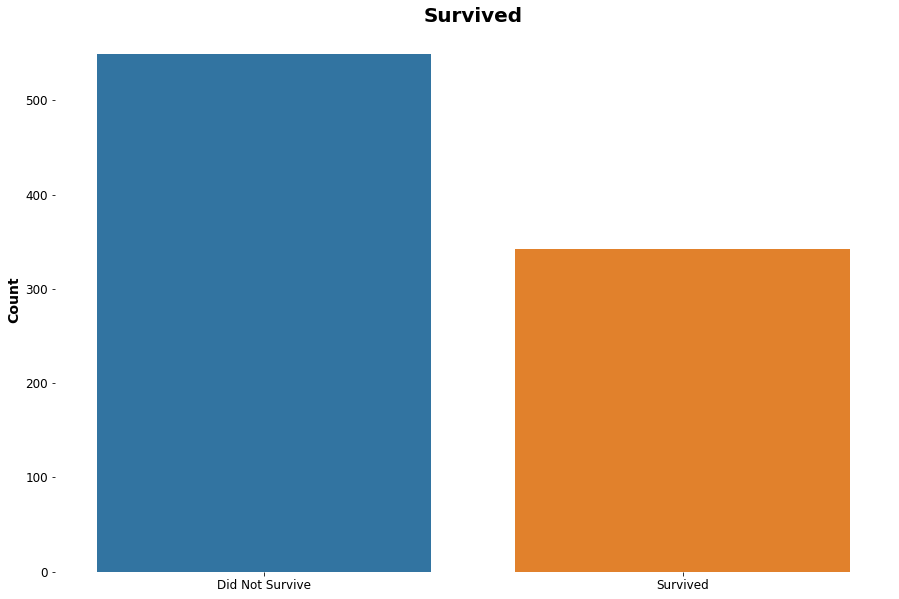

In [81]:
print('Percent Survived: ' ,round((len(train_df[train_df['Survived'] == 0]) / len(train_df)) * 100, 2), '%', sep = '')
print('Percent Did Not Survive: ' ,round((len(train_df[train_df['Survived'] == 1]) / len(train_df)) * 100, 2), '%', sep = '')

plt.figure(figsize = (15, 10))
plt.title('Survived', fontdict = {'size': 20, 'weight': 'bold'})
sns.countplot(x = train_df['Survived Description'])
plt.legend('', framealpha = 0)
plt.box(False)
plt.ylabel('Count', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(fontsize = 12)
plt.xlabel('')
plt.xticks(fontsize = 12)
plt.show()

### NAs in Data Set

                  Column  Count_NA  Percent_NA
0            PassengerId         0    0.000000
1               Survived         0    0.000000
2           Ticket Class         0    0.000000
3                   Name         0    0.000000
4                    Sex         0    0.000000
5                    Age       177    0.198653
6   Siblings and Spouses         0    0.000000
7   Parents and Children         0    0.000000
8                 Ticket         0    0.000000
9                   Fare         0    0.000000
10                 Cabin       687    0.771044
11              Embarked         2    0.002245
12  Survived Description         0    0.000000
13      Missing Features         0    0.000000
14          Cabin Letter       687    0.771044
15      Ticket Frequency         0    0.000000
16        Fare Frequency         0    0.000000


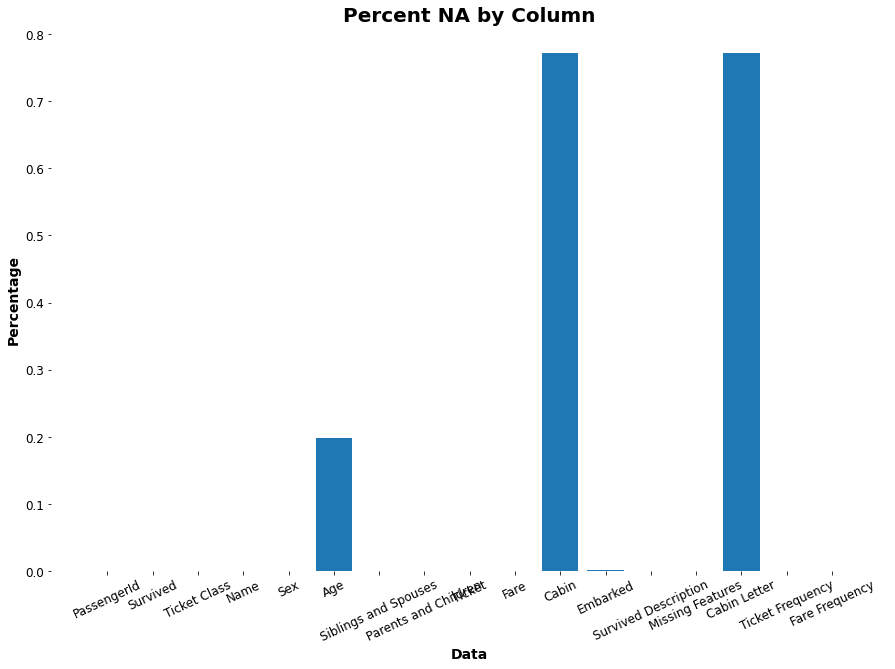

In [82]:
cols = []
count_na = []
percent_na = []

for i in range(len(train_df.isnull().sum(axis = 0))):
    cols.append(train_df.columns[i])
    count_na.append(train_df.isnull().sum(axis = 0)[i])
    percent_na.append(train_df.isnull().sum(axis = 0)[i] / len(train_df))
    
na_by_column = pd.DataFrame(
    {
        'Column': cols,
        'Count_NA': count_na,
        'Percent_NA': percent_na
    }
)

print(na_by_column)

plt.figure(figsize = [15, 10])
plt.bar(data = na_by_column, x = 'Column', height = 'Percent_NA')
plt.box(False)
plt.xlabel('Data', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(fontsize = 12, rotation = 25)
plt.ylabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(fontsize = 12)
plt.title('Percent NA by Column', fontdict = {'size': 20, 'weight': 'bold'})
plt.show()

### Numerical Variables

In [83]:
num_cols = ['Age', 'Ticket Class', 'Ticket Frequency', 'Siblings and Spouses', 'Parents and Children', 'Fare', 'Fare Frequency', 'Missing Features']
categorical_cols = ['Ticket Class', 'Sex', 'Cabin Letter', 'Embarked']

Age
--------------------
Skew : 0.39
Mean: 29.7
Median: 28.0
Standard Deviation: 14.52
Percent NA: 19.87%

Mean (Survived): 28.34
Mean (Did Not Survive): 30.63


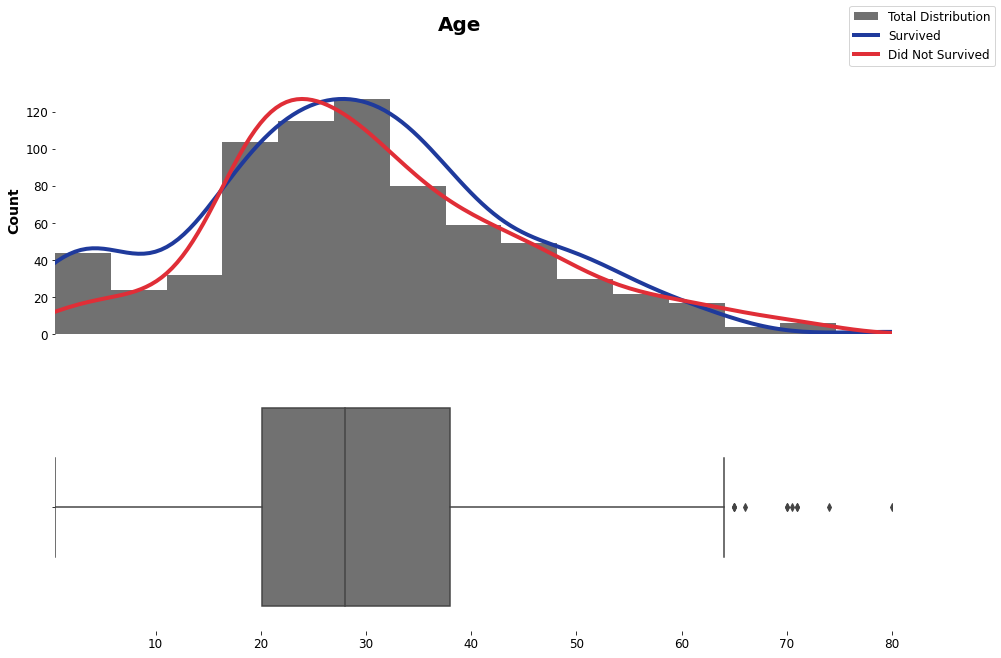

Ticket Class
--------------------
Skew : -0.63
Mean: 2.31
Median: 3.0
Standard Deviation: 0.84
Percent NA: 0.0%

Mean (Survived): 1.95
Mean (Did Not Survive): 2.53


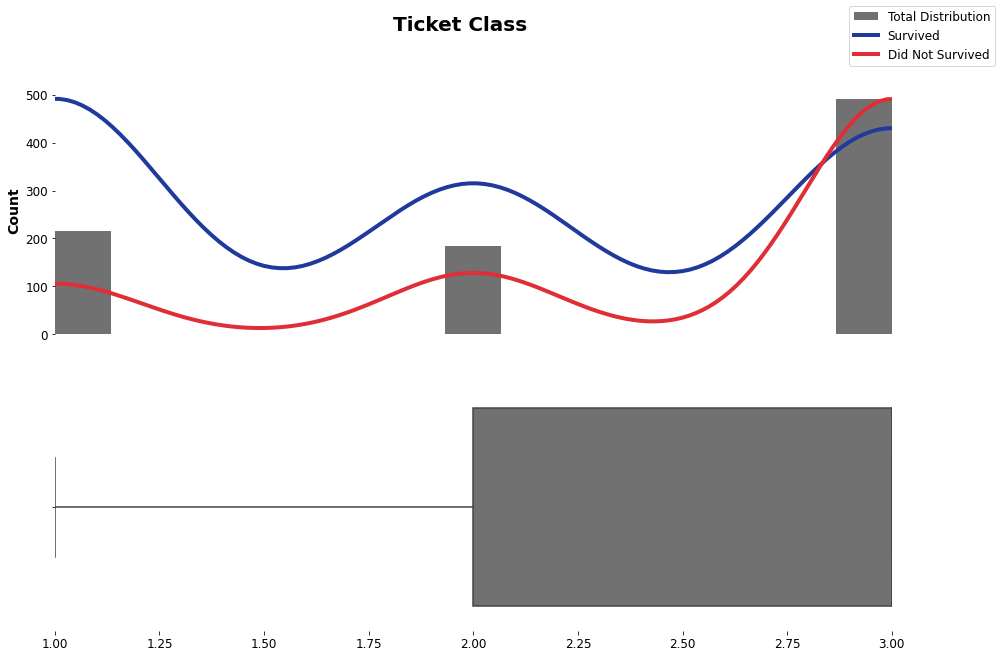

Ticket Frequency
--------------------
Skew : 2.26
Mean: 2.12
Median: 1.0
Standard Deviation: 1.8
Percent NA: 0.0%

Mean (Survived): 2.27
Mean (Did Not Survive): 2.03


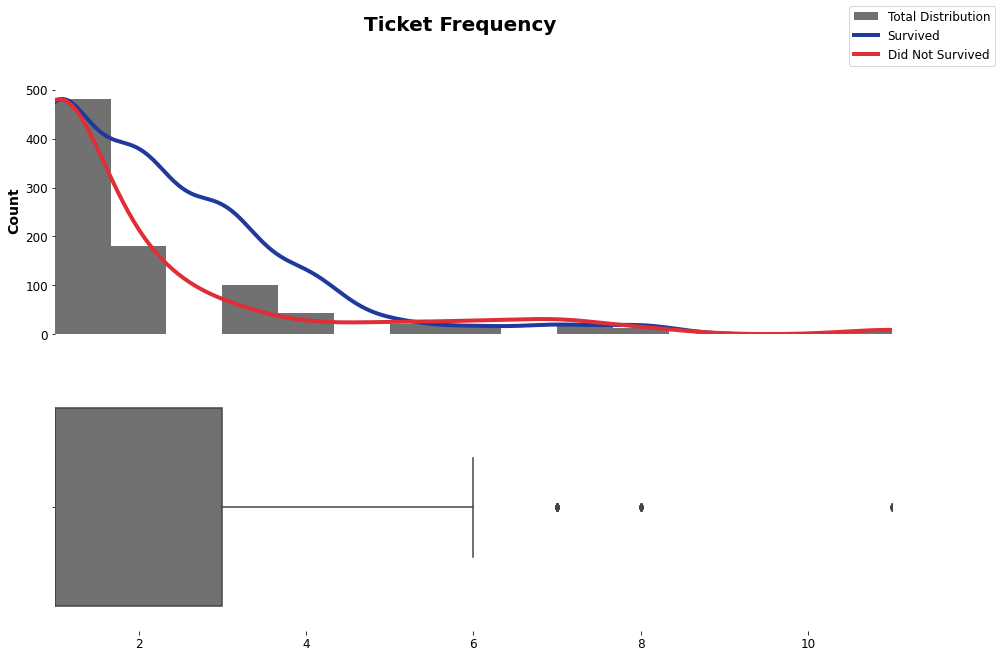

Siblings and Spouses
--------------------
Skew : 3.7
Mean: 0.52
Median: 0.0
Standard Deviation: 1.1
Percent NA: 0.0%

Mean (Survived): 0.47
Mean (Did Not Survive): 0.55


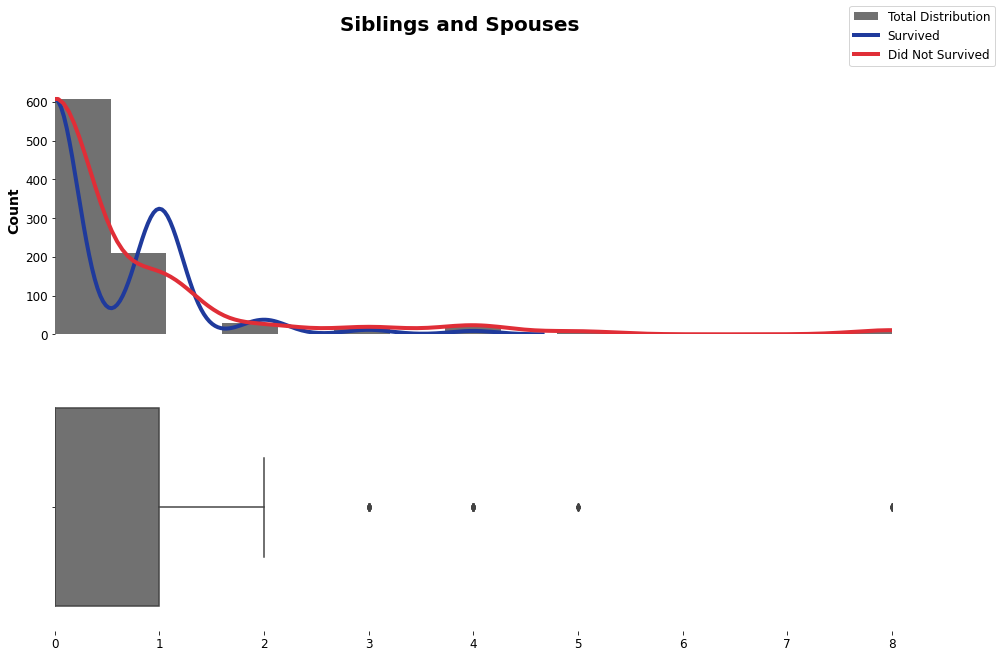

Parents and Children
--------------------
Skew : 2.75
Mean: 0.38
Median: 0.0
Standard Deviation: 0.81
Percent NA: 0.0%

Mean (Survived): 0.46
Mean (Did Not Survive): 0.33


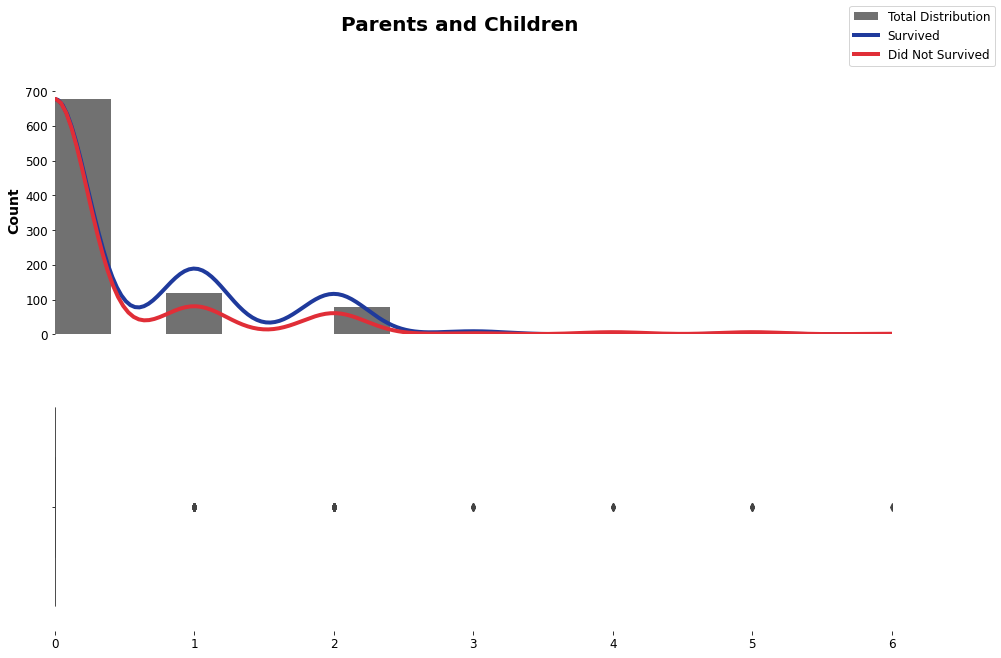

Fare
--------------------
Skew : 4.79
Mean: 32.2
Median: 14.45
Standard Deviation: 49.67
Percent NA: 0.0%

Mean (Survived): 48.4
Mean (Did Not Survive): 22.12


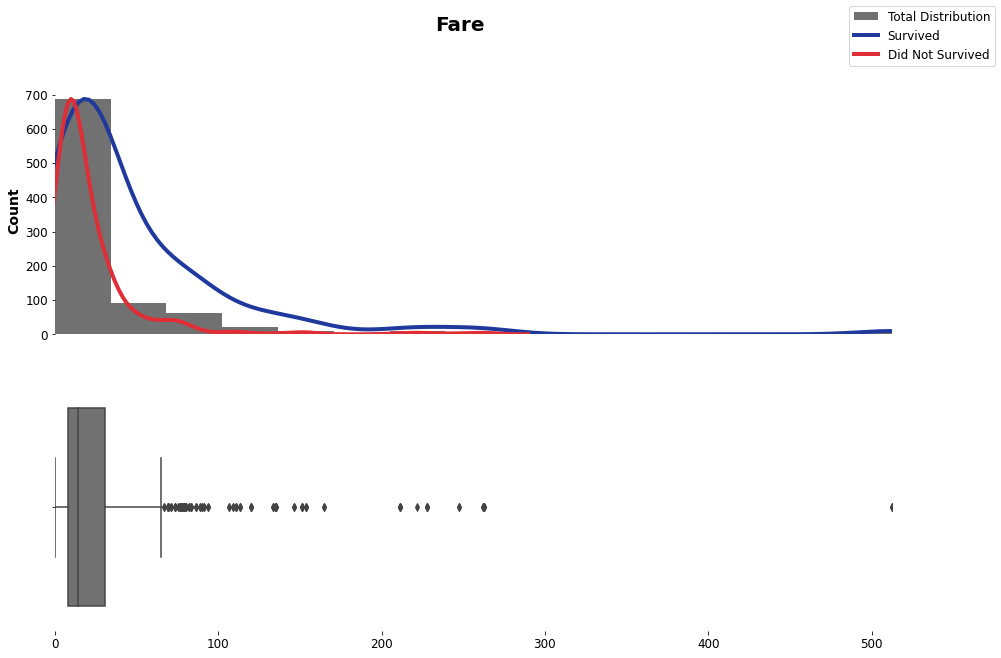

Fare Frequency
--------------------
Skew : 1.04
Mean: 18.73
Median: 8.0
Standard Deviation: 20.38
Percent NA: 0.0%

Mean (Survived): 14.18
Mean (Did Not Survive): 21.56


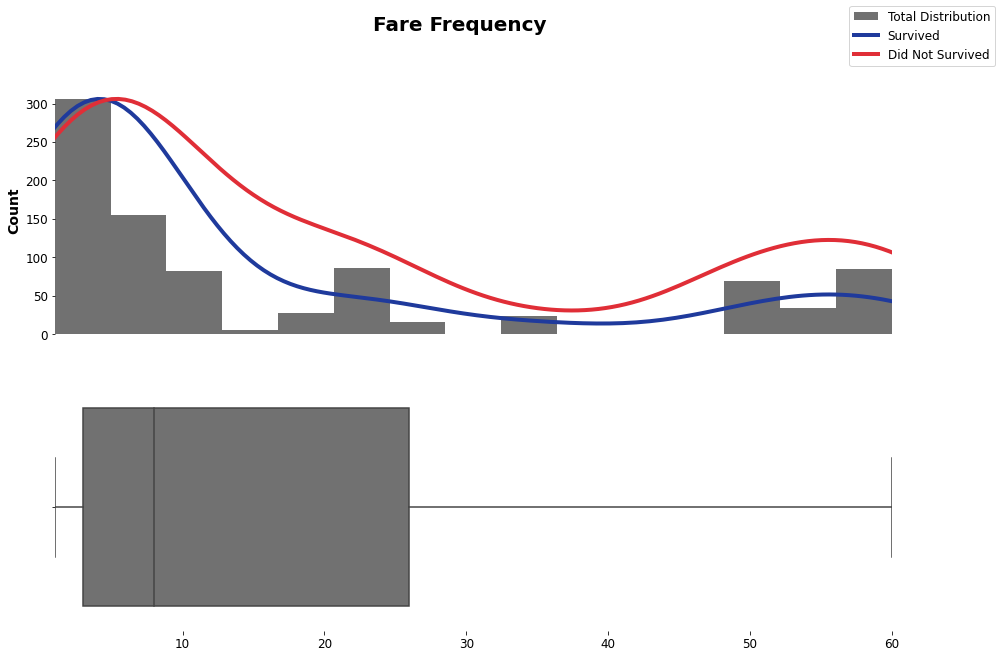

Missing Features
--------------------
Skew : 0.02
Mean: 0.97
Median: 1.0
Standard Deviation: 0.62
Percent NA: 0.0%

Mean (Survived): 0.76
Mean (Did Not Survive): 1.1


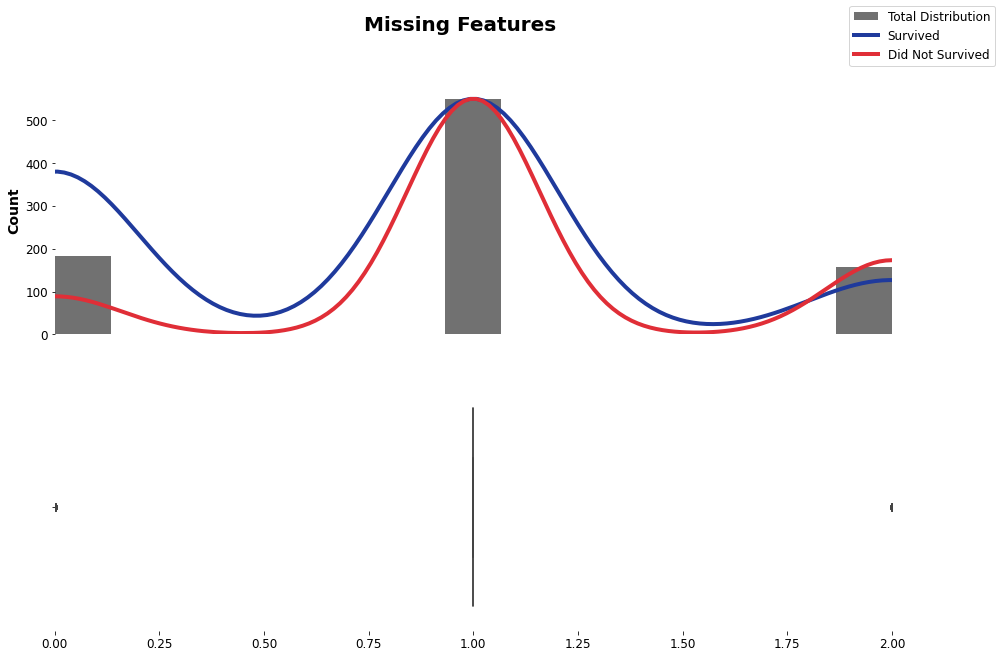

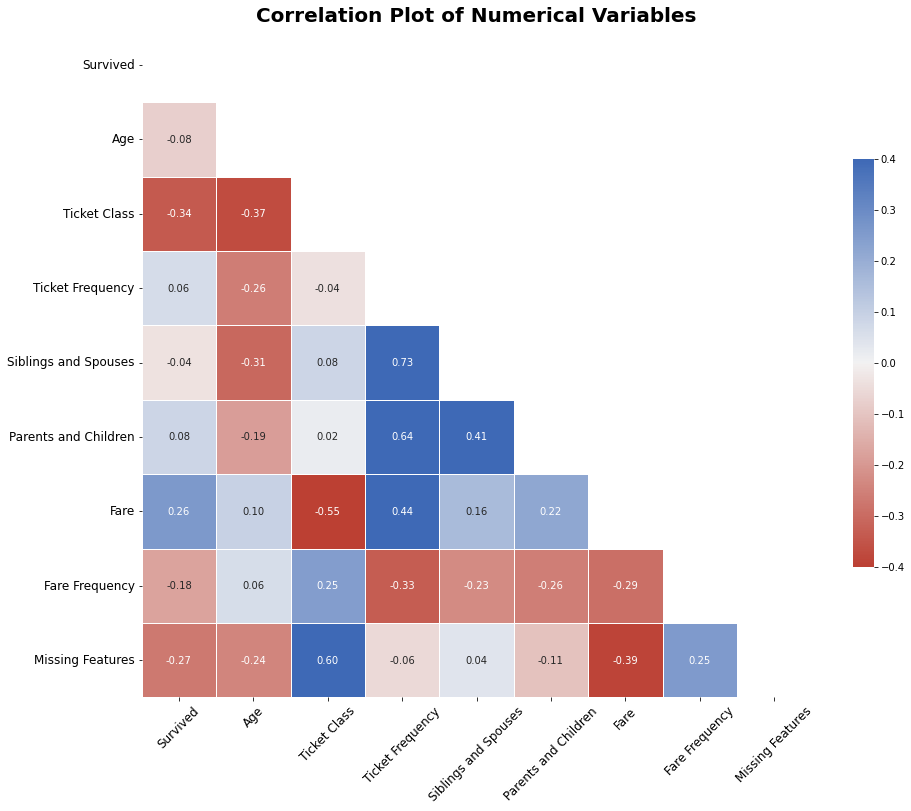

In [84]:
survived_train_df = train_df[train_df['Survived'] == 1]
died_train_df = train_df[train_df['Survived'] == 0]

for col in num_cols:
    print(col)
    
    print('--------------------')
    
    print('Skew :',round(train_df[col].skew(), 2))
    print('Mean:', '{:,}'.format(round(np.mean(train_df[col]), 2)))
    print('Median:', '{:,}'.format(round(np.nanmedian(train_df[col]), 2)))
    print('Standard Deviation:', '{:,}'.format(round(np.std(train_df[col]), 2)))
    print('Percent NA: ', round((train_df[col].isnull().sum() / len(train_df)) * 100, 2), '%', sep = '')
    print()
    print('Mean (Survived):', '{:,}'.format(round(np.mean(survived_train_df[col]), 2)))
    print('Mean (Did Not Survive):', '{:,}'.format(round(np.mean(died_train_df[col]), 2)))
    
    plt.figure(figsize = (15, 10))
    plt.suptitle(col, size = 20, weight = 'bold')
    
    # plot 1: histogram and density plot
    plt.subplot(2, 1, 1)
    
    plt.hist(x = train_df[col], bins = 15, color = '#717171', label = 'Total Distribution')
    plt.xlim(np.min(train_df[col]), np.max(train_df[col]))
    plt.box(False)
    plt.ylabel('Count', fontdict = {'size': 14, 'weight': 'bold'})
    plt.yticks(fontsize = 12)
    plt.xticks(labels = [], ticks = [])
    
    plt.twinx()
    sns.kdeplot(x = survived_train_df[col], color = '#1F3A9C', linewidth = 4, label = 'Survived')
    plt.box(False)
    plt.ylabel('')
    plt.yticks(labels = [], ticks = [])
    plt.xticks(labels = [], ticks = [])
    
    plt.twinx()
    sns.kdeplot(x = died_train_df[col], color = '#E02E37', linewidth = 4, label = 'Did Not Survived')
    plt.box(False)
    plt.ylabel('')
    plt.yticks(labels = [], ticks = [])
    plt.xticks(labels = [], ticks = [])
    
    plt.figlegend(fontsize = 12)
    
    # plot 2: boxplot
    plt.subplot(2, 1, 2)
    
    sns.boxplot(x = train_df[col], color = '#717171')
    plt.box(False)
    plt.xlim(np.min(train_df[col]), np.max(train_df[col]))
    plt.xlabel('')
    plt.xticks(fontsize = 12)
    
    plt.show()
    
# correlation plot
plt.figure(figsize = (15, 15))

corr_col = ['Survived', 'Age', 'Ticket Class', 'Ticket Frequency', 'Siblings and Spouses', 'Parents and Children', 'Fare', 'Fare Frequency', 'Missing Features']
num_corr = train_df[corr_col].corr()
num_mask = np.triu(np.ones_like(num_corr, dtype=bool))
cmap = sns.diverging_palette(h_neg = 15, h_pos = 255, s = 75, l = 45, sep = 1, center = 'light', as_cmap = True)

sns.heatmap(num_corr, mask = num_mask, cmap = cmap, vmin = -.4, vmax=.4, center=0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": .5}, annot = True, fmt = ".2f")
plt.title('Correlation Plot of Numerical Variables', fontdict = {'size': 20, 'weight': 'bold'})
plt.xticks(fontsize = 12, rotation = 45)
plt.yticks(fontsize = 12)
plt.show()


### Categorical Variables

Ticket Class
--------------------
Percent NA: 0.0%


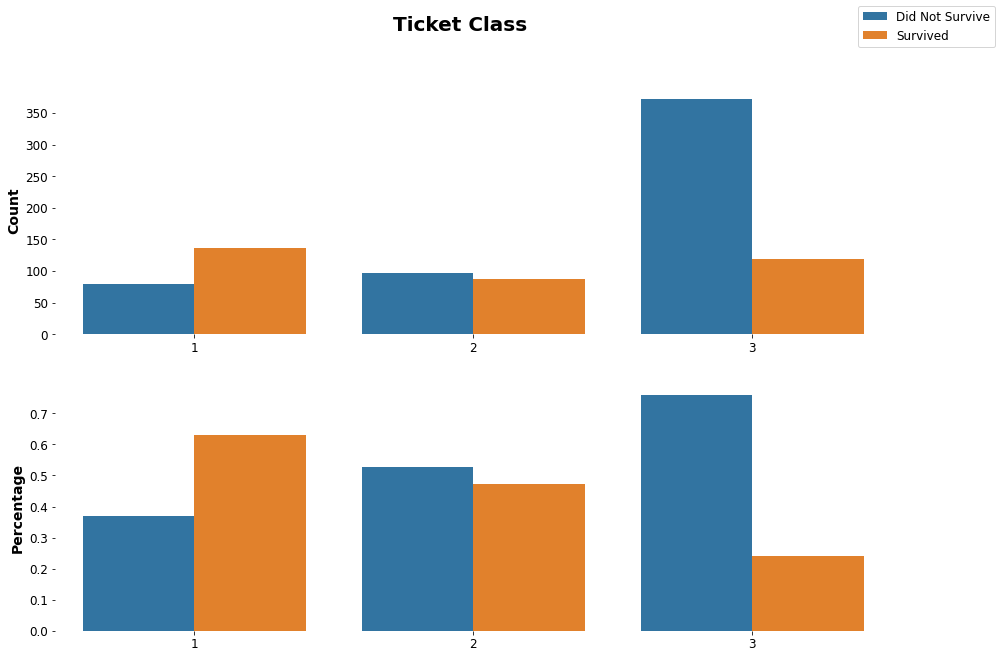

Sex
--------------------
Percent NA: 0.0%


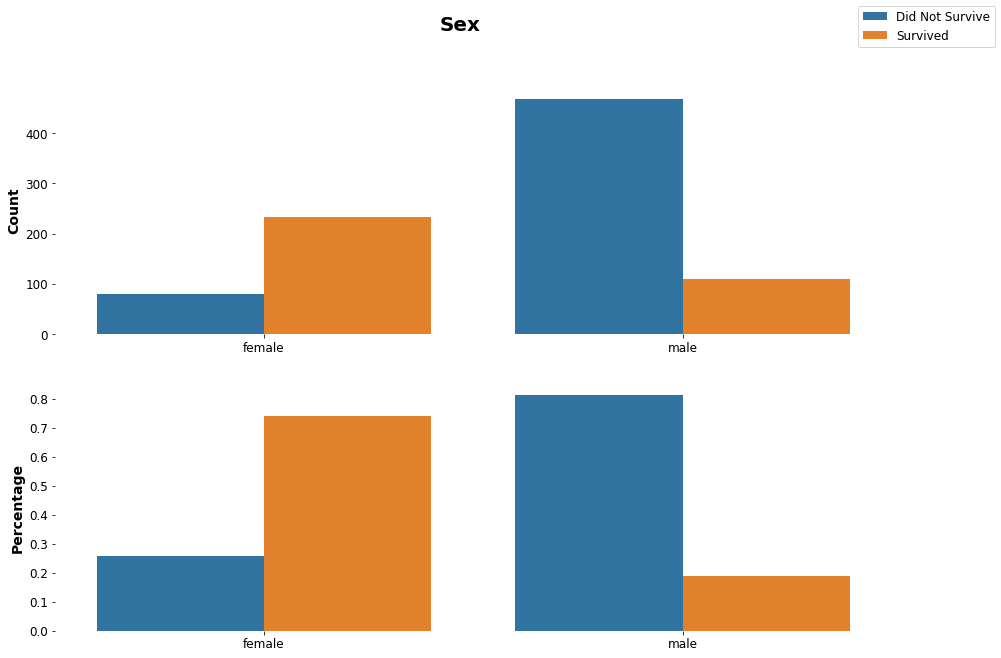

Cabin Letter
--------------------
Percent NA: 77.1%


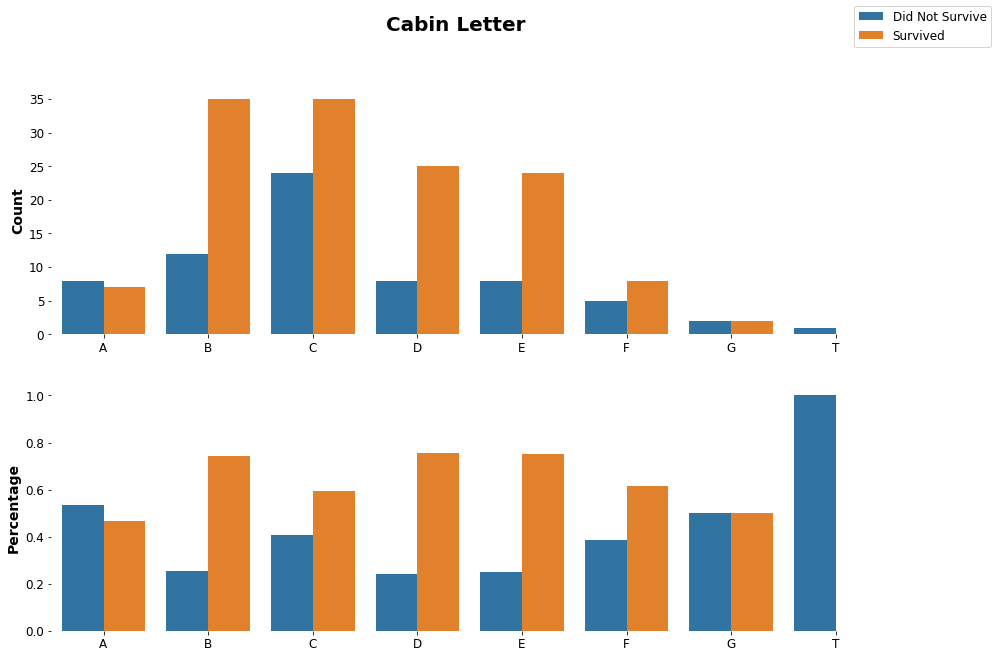

Embarked
--------------------
Percent NA: 0.22%


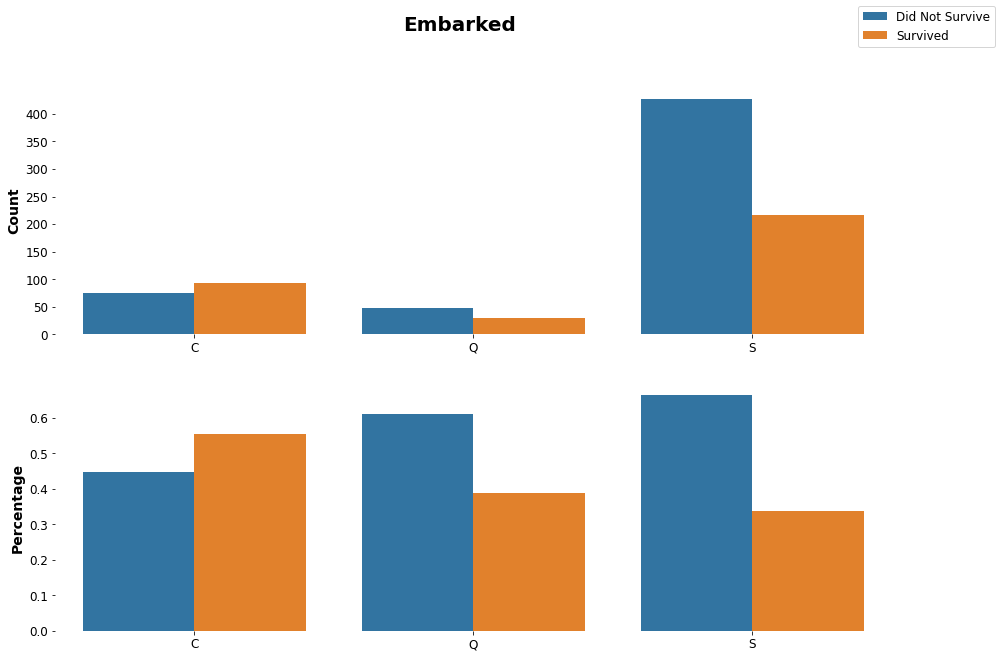

In [85]:
for col in categorical_cols:
    # creating dictionary for visualization x axis order
    
    categorical_cols = ['Ticket Class', 'Sex', 'Cabin Letter', 'Embarked']
    
    label_dic = {
        'Ticket Class': [1, 2, 3],
        'Sex': ['female', 'male'],
        'Cabin Letter': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'],
        'Embarked': ['C', 'Q', 'S']
    }
    
    # printing out descriptive statistics
    print(col)
    print('--------------------')
    print('Percent NA: ', round((train_df[col].isnull().sum() / len(train_df)) * 100, 2), '%', sep = '')
    
    # initializing figure
    plt.figure(figsize = (15, 10))
    plt.suptitle(col, size = 20, weight = 'bold')
    
    # plot 1: bar plot with counts
    plt.subplot(2, 1, 1)

    sns.countplot(x = train_df[col], hue = train_df['Survived Description'], order = label_dic[col])
    plt.legend('', framealpha = 0)
    plt.box(False)
    plt.xlabel('')
    plt.xticks(fontsize = 12)
    plt.ylabel('Count', fontdict = {'size': 14, 'weight': 'bold'})
    plt.yticks(fontsize = 12)
    plt.figlegend(fontsize = 12)
    
    # plot 2: bar plot with percentages
    plt.subplot(2, 1, 2)
    
    # calculating percentages by category
    counts_total = pd.DataFrame(train_df.groupby([col]).count()['PassengerId']).reset_index()
    counts = pd.DataFrame(train_df.groupby([col,'Survived Description']).count()['PassengerId']).reset_index()
    counts = pd.merge(counts, counts_total, on = col, suffixes = ['', '_Total'])
    counts['Percentage_By_Column'] = counts['PassengerId'] / counts['PassengerId_Total']
    
    sns.barplot(x = counts[col], y = counts['Percentage_By_Column'], hue = counts['Survived Description'], order = label_dic[col])
    plt.legend('', framealpha = 0)
    plt.box(False)
    plt.xlabel('')
    plt.xticks(fontsize = 12)
    plt.ylabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
    plt.yticks(fontsize = 12)
    
    plt.show()

## Preprocessing Data
---

In [86]:
# responce
train_y = train_df['Survived']
test_y = test_labels['Survived']

# gathering features
features = ['Ticket Class', 'Ticket Frequency', 'Sex', 'Age', 'Siblings and Spouses', 'Parents and Children', 'Fare', 'Fare Frequency', 'Cabin Letter', 'Embarked', 'Missing Features']

train_x = train_df[features]
test_x = test_df[features]

# creating dummy variables
train_x_dummies = pd.get_dummies(train_x[['Sex', 'Cabin Letter', 'Embarked']])
train_x = pd.concat([train_x, train_x_dummies], axis=1)
train_x.drop(['Sex', 'Cabin Letter', 'Embarked', 'Cabin Letter_T'], inplace = True, axis = 1)

test_x_dummies = pd.get_dummies(test_x[['Sex', 'Cabin Letter', 'Embarked']])
test_x = pd.concat([test_x, test_x_dummies], axis=1)
test_x.drop(['Sex', 'Cabin Letter', 'Embarked'], inplace = True, axis = 1)

# power transform data
power_cols = ['Ticket Class', 'Ticket Frequency', 'Age', 'Siblings and Spouses', 'Parents and Children', 'Fare', 'Fare Frequency', 'Missing Features']

power_features_train = train_x[power_cols]
power_features_test = test_x[power_cols]
power_trans =  PowerTransformer().fit(power_features_train.values)

train_x[power_cols] = power_trans.transform(power_features_train.values)
test_x[power_cols] = power_trans.transform(power_features_test.values)

# center and scale data
scale_cols = ['Ticket Class', 'Ticket Frequency', 'Age', 'Siblings and Spouses', 'Parents and Children', 'Fare', 'Fare Frequency', 'Missing Features']

scale_features_train = train_x[scale_cols]
scale_features_test = test_x[scale_cols]
scaler = StandardScaler().fit(scale_features_train.values)

train_x[scale_cols] = scaler.transform(scale_features_train.values)
test_x[scale_cols] = scaler.transform(scale_features_test.values)
    
# impute missing values
train_x_columns = train_x.columns
test_x_columns = test_x.columns

knn_imputer = KNNImputer(n_neighbors = 10, weights = 'uniform').fit(train_x)

train_x = knn_imputer.transform(train_x)
train_x = pd.DataFrame(train_x, columns = train_x_columns)

test_x = knn_imputer.transform(test_x)
test_x = pd.DataFrame(test_x, columns = test_x_columns)

# printing details and statistics    
print("Feature training set dimensions: ", train_x.shape)   
print("Feature test set dimensions:", test_x.shape)
print("Features:")
for i in train_x.columns:
    print(' -',i)
print()

print("Responce distribution training set:")
print(train_y.value_counts(normalize = True))
print()

Feature training set dimensions:  (891, 20)
Feature test set dimensions: (418, 20)
Features:
 - Ticket Class
 - Ticket Frequency
 - Age
 - Siblings and Spouses
 - Parents and Children
 - Fare
 - Fare Frequency
 - Missing Features
 - Sex_female
 - Sex_male
 - Cabin Letter_A
 - Cabin Letter_B
 - Cabin Letter_C
 - Cabin Letter_D
 - Cabin Letter_E
 - Cabin Letter_F
 - Cabin Letter_G
 - Embarked_C
 - Embarked_Q
 - Embarked_S

Responce distribution training set:
0    0.616162
1    0.383838
Name: Survived, dtype: float64



## Developing Classification Models
---

In [87]:
def fit_classification_model(name, model, parameters, x, y):
    # fit model based on parameters given
    grid_obj = GridSearchCV(model, parameters, scoring = metrics.make_scorer(accuracy_score), cv = 5)
    grid_obj = grid_obj.fit(x, y)
    model = grid_obj.best_estimator_
    
    model_fits = pd.DataFrame(grid_obj.cv_results_)
    model_fits = model_fits.sort_values('rank_test_score').reset_index(drop = True)
    
    # saving model accuracy and error
    model_accuracy = model_fits['mean_test_score'][0]
    model_error = model_fits['std_test_score'][0]
    
    # saving model fits, accuracy, and error as model attributes
    model.fits = model_fits
    model.accuracy = model_accuracy
    model.error = model_error
    
    # make predictions on dataset and store them in train dataframe
    pred_prob = model.predict_proba(x)[:,[1]]
    pred_prob_col = name + '_predict_proba'
    
    pred_df = x.copy()
    pred_df[pred_prob_col] = pred_prob
    
    return(model, pred_df)

In [88]:
def execute_classification_model(name, model, x):
    # make predictions on dataset and store them in train dataframe
    pred_prob = model.predict_proba(x)[:,[1]]
    pred_prob_col = name + '_predict_proba'
    
    pred_df = x.copy()
    pred_df[pred_prob_col] = pred_prob
    
    return(pred_df)

In [89]:
train_x.columns

Index(['Ticket Class', 'Ticket Frequency', 'Age', 'Siblings and Spouses',
       'Parents and Children', 'Fare', 'Fare Frequency', 'Missing Features',
       'Sex_female', 'Sex_male', 'Cabin Letter_A', 'Cabin Letter_B',
       'Cabin Letter_C', 'Cabin Letter_D', 'Cabin Letter_E', 'Cabin Letter_F',
       'Cabin Letter_G', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [90]:
model_features = ['Ticket Class', 'Ticket Frequency', 'Age', 'Siblings and Spouses', 'Parents and Children', 'Fare', 'Fare Frequency', 'Missing Features', 'Sex_female', 'Sex_male', 'Cabin Letter_A', 'Cabin Letter_B', 'Cabin Letter_C', 'Cabin Letter_D', 'Cabin Letter_E', 'Cabin Letter_F', 'Cabin Letter_G', 'Embarked_C']
train_x = train_x[model_features]
test_x = test_x[model_features]

### Logistic Regression

In [91]:
np.random.seed(101010)

log_parameters = {
    'class_weight': [{0: 0.45, 1: 0.55}],
    'penalty': ['l2'],
    'max_iter': [1000],
    'tol': [1e-2],
    'C': [7],
    'solver': ['sag']
    }

log, log_predictions_df = fit_classification_model('logit', LogisticRegression(), log_parameters, train_x, train_y)
log_test_predictions_df = execute_classification_model('log', log, test_x)
test_pred = log.predict(test_x)
print(classification_report(test_y, test_pred))
print(confusion_matrix(test_y, test_pred))


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       260
           1       0.65      0.71      0.68       158

    accuracy                           0.75       418
   macro avg       0.73      0.74      0.73       418
weighted avg       0.75      0.75      0.75       418

[[200  60]
 [ 46 112]]


### KNN

In [92]:
knn_features = ['Ticket Class', 'Ticket Frequency', 'Age', 'Fare', 'Fare Frequency',
       'Sex_female', 'Sex_male', 'Cabin Letter_A', 'Cabin Letter_C',
       'Cabin Letter_F', 'Cabin Letter_G', 'Embarked_C']

In [93]:
np.random.seed(101010)

knn_parameters = {
    'algorithm': ['auto'],
    'metric': ['minkowski'],
    'n_neighbors': [29],
    'p': [2],
    'weights': ['uniform']
}

knn, knn_predictions_df = fit_classification_model('knn', KNeighborsClassifier(), knn_parameters, train_x[knn_features], train_y)
knn_test_predictions_df = execute_classification_model('knn', knn, test_x[knn_features])
test_pred = knn.predict(test_x[knn_features])
print(classification_report(test_y, test_pred))
print(confusion_matrix(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       260
           1       0.74      0.63      0.68       158

    accuracy                           0.78       418
   macro avg       0.76      0.75      0.75       418
weighted avg       0.77      0.78      0.77       418

[[224  36]
 [ 58 100]]


### Random Forest

In [94]:
np.random.seed(101010)

rf_parameters = {
    'class_weight': [{0: 40, 1: 60}],
    'criterion': ['entropy'],
    'max_depth': [10],
    'min_samples_leaf': [12],
    'min_samples_split': [16],
    'n_estimators': [25],
    'max_depth': [10],
    'max_features': [0.5]
}

rf, rf_predictions_df = fit_classification_model('rf', RandomForestClassifier(), rf_parameters, train_x, train_y)
rf_test_predictions_df = execute_classification_model('rf', rf, test_x)
test_pred = rf.predict(test_x)
print(classification_report(test_y, test_pred))
print(confusion_matrix(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       260
           1       0.67      0.70      0.68       158

    accuracy                           0.75       418
   macro avg       0.74      0.74      0.74       418
weighted avg       0.76      0.75      0.75       418

[[205  55]
 [ 48 110]]


### Support Vector Machine

In [95]:
np.random.seed(101010)

svm_parameters = {
    'class_weight': [{0: 40, 1: 60}],
    'C': [0.1],
    'kernel': ['rbf'],
    'gamma': ['auto'],
    'tol': [1e-1],
    'probability': [True],
    'cache_size': [5000]
}

svm, svm_predictions_df = fit_classification_model('svm', SVC(), svm_parameters, train_x, train_y)
svm_test_predictions_df = execute_classification_model('svm', svm, test_x)
test_pred = svm.predict(test_x)
print(classification_report(test_y, test_pred))
print(confusion_matrix(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       260
           1       0.66      0.73      0.70       158

    accuracy                           0.76       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.77      0.76      0.76       418

[[201  59]
 [ 42 116]]


### Neural Network

In [96]:
np.random.seed(101010)

nn_parameters = {
    'hidden_layer_sizes': [(90)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [1e-6],
    'learning_rate_init': [1e-3],
    'learning_rate': ['adaptive'],
    'tol': [1e-4]
}

nn, nn_predictions_df = fit_classification_model('nn', MLPClassifier(), nn_parameters, train_x, train_y)
nn_test_predictions_df = execute_classification_model('nn', nn, test_x)
test_pred = nn.predict(test_x)
print(classification_report(test_y, test_pred))
print(confusion_matrix(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       260
           1       0.68      0.66      0.67       158

    accuracy                           0.76       418
   macro avg       0.74      0.74      0.74       418
weighted avg       0.75      0.76      0.76       418

[[212  48]
 [ 54 104]]


### Model Performances and Predictions

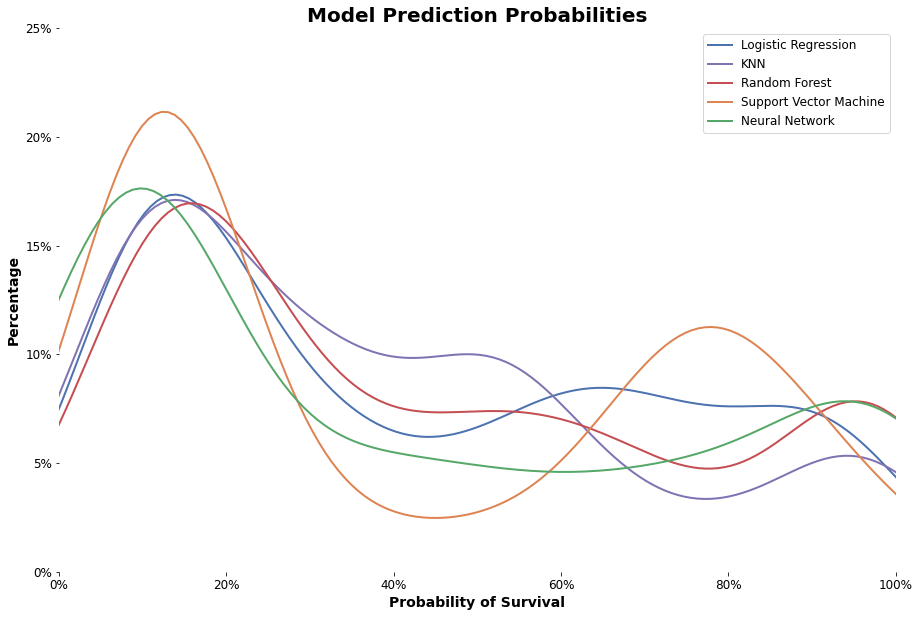

In [97]:
plt.figure(figsize = (15, 10))

sns.kdeplot(x = log_test_predictions_df['log_predict_proba'], color = '#4C72B0', linewidth = 2, label = 'Logistic Regression')
sns.kdeplot(x = knn_test_predictions_df['knn_predict_proba'], color = '#8172B3', linewidth = 2, label = 'KNN')
sns.kdeplot(x = rf_test_predictions_df['rf_predict_proba'], color = '#C44E52', linewidth = 2, label = 'Random Forest')
sns.kdeplot(x = svm_test_predictions_df['svm_predict_proba'], color = '#DD8452', linewidth = 2, label = 'Support Vector Machine')
sns.kdeplot(x = nn_test_predictions_df['nn_predict_proba'], color = '#55A868', linewidth = 2, label = 'Neural Network')

plt.legend(fontsize = 12)

plt.title('Model Prediction Probabilities', fontdict = {'size': 20, 'weight': 'bold'})
plt.box(False)
plt.xlabel('Probability of Survival', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
           labels = ['0%', '20%', '40%', '60%', '80%', '100%'], 
           fontsize = 12)
plt.xlim(0, 1)
plt.ylabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(ticks = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5], 
           labels = ['0%', '5%', '10%', '15%', '20%', '25%'], 
           fontsize = 12)

plt.show()

In [98]:
test_predictions_df = test_x.copy()
test_predictions_df['log_predict_proba'] = log_test_predictions_df['log_predict_proba']
test_predictions_df['knn_predict_proba'] = knn_test_predictions_df['knn_predict_proba']
test_predictions_df['rf_predict_proba'] = rf_test_predictions_df['rf_predict_proba']
test_predictions_df['svm_predict_proba'] = svm_test_predictions_df['svm_predict_proba']
test_predictions_df['nn_predict_proba'] = nn_test_predictions_df['nn_predict_proba']

In [99]:
test_predictions_df['avg_predict_proba'] = test_predictions_df.filter(regex = 'proba$', axis = 1).mean(axis = 1)

most_confident_predict_proba = []

for i in range(len(test_predictions_df)):
    pred_df = test_predictions_df.filter(regex = 'proba$', axis = 1)
    values = []
    for col in test_predictions_df.filter(regex = 'proba$', axis = 1).columns:
        values.append(np.abs(test_predictions_df[col][i] - 0.5))
        
    if values[0] == np.max(values):
        most_confident_predict_proba.append(pred_df.iloc[:,0][i])
    elif values[1] == np.max(values):
        most_confident_predict_proba.append(pred_df.iloc[:,1][i])
    elif values[2] == np.max(values):
        most_confident_predict_proba.append(pred_df.iloc[:,2][i])
    elif values[3] == np.max(values):
        most_confident_predict_proba.append(pred_df.iloc[:,3][i])
    elif values[4] == np.max(values):
        most_confident_predict_proba.append(pred_df.iloc[:,4][i])
    else:
        most_confident_predict_proba.append(pred_df.iloc[:,5][i])

test_predictions_df['most_confident_predict_proba'] = most_confident_predict_proba

In [100]:
for col in test_predictions_df.filter(regex = 'proba$', axis = 1).columns:
    test_pred = []
    
    for i in range(len(test_predictions_df)):
        if test_predictions_df[col][i] >= 0.5:
            test_pred.append(1)
        else:
            test_pred.append(0)
    print(col)      
    print(classification_report(test_y, test_pred))
    print(confusion_matrix(test_y, test_pred))
    print()

log_predict_proba
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       260
           1       0.65      0.71      0.68       158

    accuracy                           0.75       418
   macro avg       0.73      0.74      0.73       418
weighted avg       0.75      0.75      0.75       418

[[200  60]
 [ 46 112]]

knn_predict_proba
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       260
           1       0.74      0.63      0.68       158

    accuracy                           0.78       418
   macro avg       0.76      0.75      0.75       418
weighted avg       0.77      0.78      0.77       418

[[224  36]
 [ 58 100]]

rf_predict_proba
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       260
           1       0.67      0.70      0.68       158

    accuracy                           0.75       418
   macro avg       0.74    

In [23]:
# creating binary classifier
survived_prediction = []

for i in range(len(test_x)):
    if test_predictions_df['avg_predict_proba'][i] >= 0.50:
        survived_prediction.append(1)
    else:
        survived_prediction.append(0)
        
final_submission = test_df[['PassengerId']]
final_submission['Survived'] = survived_prediction
final_submission.to_csv(here('projects/titanic_survival_classification/data/submission_titanic_chg.csv'), index = False)

## Evaluating Features

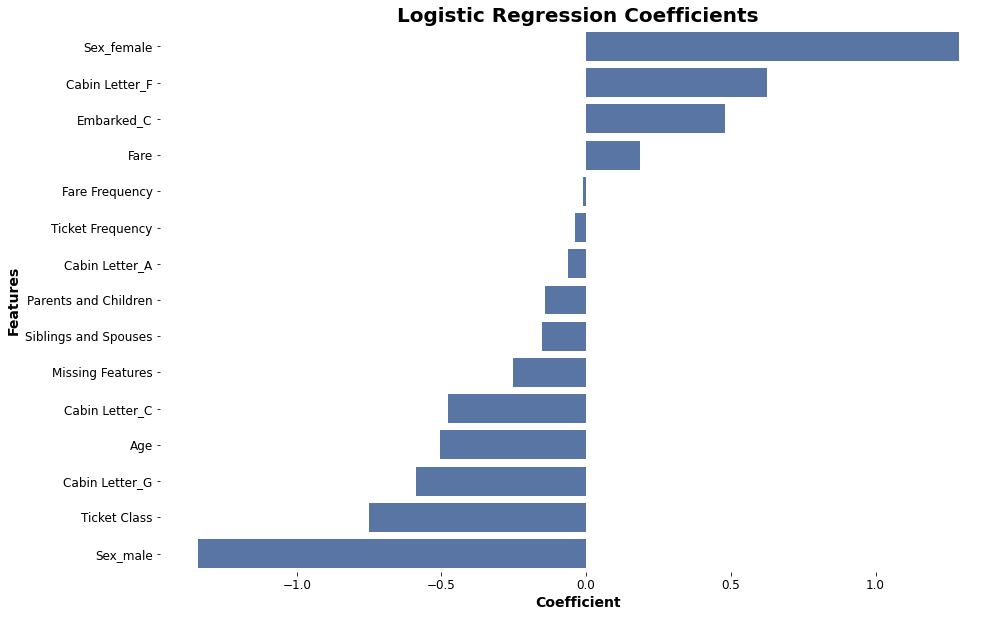

In [24]:
# plot model coefficients
log_coefficients = []

for i in range(len(train_x.columns)):
    log_coefficients.append(np.float32(log.coef_[:,i][0]))
    
log_coef_df = pd.DataFrame(
    {
        'Feature': train_x.columns,
        'Coefficient': log_coefficients
    }
)

plt.figure(figsize = (15, 10))
log_coef_df = log_coef_df.sort_values('Coefficient', ascending = False)

sns.barplot(data = log_coef_df, x = 'Coefficient', y = 'Feature', color = '#4C72B0')
plt.title('Logistic Regression Coefficients', fontdict = {'size': 20, 'weight': 'bold'})
plt.box(False)
plt.xlabel('Coefficient', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(fontsize = 12)
plt.ylabel('Features', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(fontsize = 12)
plt.show()

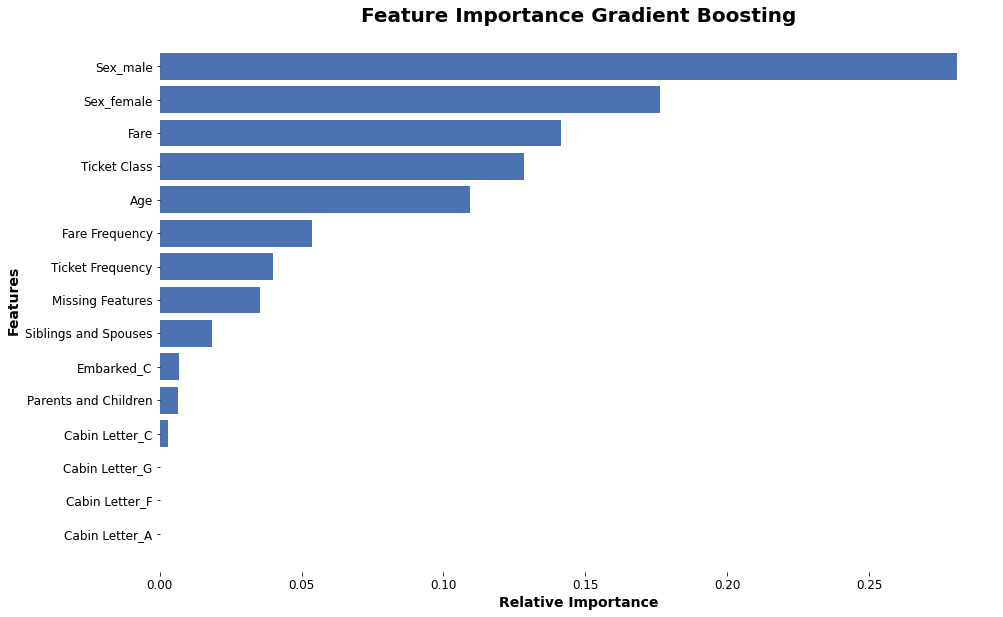

In [25]:
# plot relative feature importance from model
rf_model_importances = rf.feature_importances_
indices = np.argsort(rf_model_importances)
features = list(train_x.columns)

plt.figure(figsize = (15, 10))
plt.title('Feature Importance Gradient Boosting', fontdict = {'size': 20, 'weight': 'bold'})
plt.barh(range(len(indices)), rf_model_importances[indices], color = '#4C72B0', align = 'center')
plt.box(False)
plt.xlabel('Relative Importance', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(fontsize = 12)
plt.ylabel('Features', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize = 12)
plt.show()